In [1]:
from core import *
import utils
import time as time
from pathlib import Path
import numpy as np

In [120]:
import GPy
#path = 'c:\Users\grufi\OneDrive\Desktop\legolas\Legolas_textCellLoc-main\plots'
#SAVE = Path(path)
#SAVE.mkdir(exist_ok=True)

def Bayesian_optimization_pH():
    # Uses GPy for Gaussian Process regression as surrogate function.

    # If True, this will simulate deposition and measurement
    simulate_val = True
    
    # X_grid is the list of all possible acid-base ratios that can be investigated.
    # This is the array that will be index with next_sample_index
    X_grid = np.linspace(0.1,1,20)[:,None]
    other = np.linspace(1.1,10,20)[:,None]
    X_grid = np.append(X_grid,other)[:,None] # set of all acid and base ratios
    Dsize = X_grid.shape[0] # number in X_grid set
    print(f'x grid: {X_grid}, Dsize : {Dsize}')
    BO_lambda = .1
    
    # # set up GP.
    # X_samples = np.atleast_1d([1.])[:,None] # ratio of R to G
    # Y_samples = np.atleast_1d([210.])[:,None]
    # measured = np.asarray([14])
    # unmeasured = np.setdiff1d(np.linspace(0,14,15), measured).astype(int)
    
    # set up variables
    ratio = [1] # ratio of initial sample to study, 0 is no acid
    sample_index = 0 # index of ratio in list of ratios
    count = 0 #counter for moving to appropriate well

    # deposit first ratio in well and collect pH
    pH = BO_get_data(ratio,count) 
    print('counter value:',count)
    print('Acid/Base ratio measured:',ratio)
    print('pH Value:',pH)
    
    measured = np.atleast_1d(sample_index) # indices of ratios that have been measured
    full_indices = np.linspace(0,X_grid.shape[0]-1,X_grid.shape[0]) # indices of all ratios to be investigated
    unmeasured = np.setdiff1d(full_indices, measured).astype(int)  # indices of ratios that are still to be measured
    X_samples = np.atleast_1d(ratio)[:,None] # X_samples is the RG ratios already studied
    Y_samples = np.atleast_1d(pH)[:,None] # Y_samples are the corresponding Red measurements for the RG ratios studied.
    
    # iteration loop for active learning (GP with exploration CO)
    for iterations in range(30):
        #reset(stage=stage, pH_device=pH_device, depo_device=depo_device)
        """
        if iterations in home_check:
            # Go to Home Position
            time.sleep(10)
            reset(stage=stage, pH_device=pH_device, depo_device=depo_device)
        """
        # Regression
        k = GPy.kern.RBF(1)
        m = GPy.models.GPRegression(X_samples, Y_samples, k)
        #blockPrint() # blocks printing statements to avoid printing GPy's optimization statements.
        m.optimize_restarts(5, robust=True);
        #enablePrint() # restarts the internal printing statements
        mean_full, variance_full = m.predict(X_grid, full_cov = False) # Prediction
        print('Variance is', variance_full)
        mean, variance = m.predict(X_grid[unmeasured]) # Prediction just for unmeasured ratios
        
        # # Bayesian optimization to maximize measured red by varying mixture.
        # BO_beta = 2 * math.log(Dsize * math.pow(iterations + 1,2) * math.pow(np.pi,2) / (6 * BO_lambda) )
        # alpha = -1 * np.abs(100. - mean) + math.sqrt(BO_beta) * variance
        
        # Active Learning
        alpha_full = variance_full # variance for all ratios. use variance (uncertainty) in Gaussian Process to guide next sample
        alpha = variance # variance for unmeasured ratios
        ##alpha = (9/(iterations+1))*variance - np.absolute(mean-4.75)
        ##alpha_full = (9/(iterations+1))*variance_full - np.absolute(mean_full-4.75)
        sample_index = unmeasured[ np.argmax(alpha) ] # index of next ratio in X_grid
        ratio = X_grid[sample_index,:] # next ratio
        print('The next ratio to investigate is', ratio)

        plt.figure(figsize=(7,3))
        plot_gp(X_grid, mean_full, variance_full, training_points=(X_samples,Y_samples)) # plot GP variance for all ratios
        
        # plot
        #plt.figure(figsize = (7,3))
        num_subplots = 2
        if ~simulate_val:
            num_subplots = 3
        
        plt.figure(figsize = (10,3))
        plt.subplot(1,num_subplots,2)
        plt.plot(X_grid, alpha_full)  # plot the aquisition function for all ratios
        plt.plot([ratio, ratio],[np.min(alpha_full), np.max(alpha_full)],'m') # indicate the next ratio to be investigated
        plt.title(f'Acquisition func')
        #plt.tight_layout()
        #plt.savefig(SAVE/f"Acquisition{iterations}.png", facecolor='white')
        #plt.show()
        #plt.close()
        
        #plt.figure(figsize = (10,5))
        
        plt.subplot(1,num_subplots,1)
        plt.plot(X_grid, 2*np.sqrt(alpha_full))
        plt.title(f'2x Standard deviation')
        plt.show()
        
        '''
        plt.subplot(1,num_subplots,1)
        bottom, top = plt.ylim()
        plt.plot([ratio, ratio],[bottom, top],'m') # indicate the next ratio to investigate
        plt.title(f'Next ratio:{ratio}')
        #plt.tight_layout()
        #plt.savefig(SAVE/f"GP{iterations}.png", facecolor='white')
        plt.show()
        #plt.close()
        '''
        
           
        count+=1           #move to next well
        
        # collect data
        pH = BO_get_data(ratio, count) # run the next experiment.
        print('counter value:',count)
        print('Acid/Base ratio measured:',ratio)
        print('pH Value:',pH)
        measured = np.append(measured, sample_index) # add experiment ratio to the set of measured
        unmeasured = np.setdiff1d(full_indices, measured).astype(int)
        X_samples = np.append(X_samples, ratio)[:,None]
        Y_samples = np.append(Y_samples, pH)[:,None]
    
def BO_get_data(ratio, count):

    acid_vol,base_vol = ratio_conversion(ratio)
    print('acid_vol', acid_vol)
    print('base_vol', base_vol)   
   
    pH = 4.74 - np.log10(ratio)
    print(f"pH (HH) {pH}")
    
    #pH_device.move_to_loc("clean")
    #pH_device.to_zpos("full_down")
    #pH_device.to_zpos("full_up")

    return pH



def ratio_conversion(ratio):
    acid_vol = float(2.0*ratio[0]/(1+ratio[0]))
    base_vol = float(2.0 - acid_vol)
    return acid_vol,base_vol
            
    
def plot_gp(X, m, C, training_points=None):
    # plot results of Gaussian Process analysis.
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0], m[:,0] - 1.96*np.sqrt(np.diag(C)), m[:,0] + 1.96*np.sqrt(np.diag(C)), alpha=0.5)
    print('Cdiag = ', C[:,0])
    #alpha is opacity
    plt.title('GP model for pH')
    plt.plot(X, m, "-")  # Plot GP mean 
    plt.xlabel("x"), plt.ylabel("f")
    #plt.savefig(SAVE/f"gp{iterations}.png", facecolor='white')
    if training_points is not None:  # Plot training points if included
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.show()

x grid: [[ 0.1       ]
 [ 0.14736842]
 [ 0.19473684]
 [ 0.24210526]
 [ 0.28947368]
 [ 0.33684211]
 [ 0.38421053]
 [ 0.43157895]
 [ 0.47894737]
 [ 0.52631579]
 [ 0.57368421]
 [ 0.62105263]
 [ 0.66842105]
 [ 0.71578947]
 [ 0.76315789]
 [ 0.81052632]
 [ 0.85789474]
 [ 0.90526316]
 [ 0.95263158]
 [ 1.        ]
 [ 1.1       ]
 [ 1.56842105]
 [ 2.03684211]
 [ 2.50526316]
 [ 2.97368421]
 [ 3.44210526]
 [ 3.91052632]
 [ 4.37894737]
 [ 4.84736842]
 [ 5.31578947]
 [ 5.78421053]
 [ 6.25263158]
 [ 6.72105263]
 [ 7.18947368]
 [ 7.65789474]
 [ 8.12631579]
 [ 8.59473684]
 [ 9.06315789]
 [ 9.53157895]
 [10.        ]], Dsize : 40
acid_vol 1.0
base_vol 1.0
pH (HH) [4.74]
counter value: 0
Acid/Base ratio measured: [1]
pH Value: [4.74]
Optimization restart 1/5, f = 2.9749756689647193
Optimization restart 2/5, f = 2.9749756689654716
Optimization restart 3/5, f = 2.9749756693138103
Optimization restart 4/5, f = 2.9749756702843784
Optimization restart 5/5, f = 2.97497567362486
Variance is [[19.9685858 ]
 [19

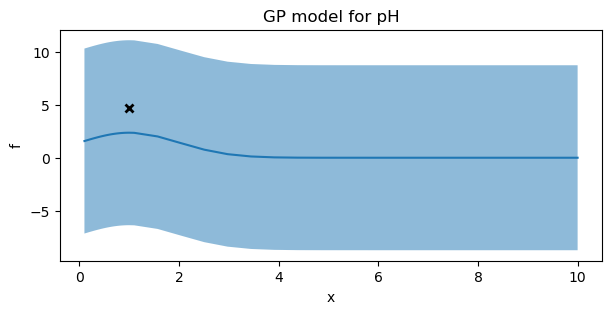

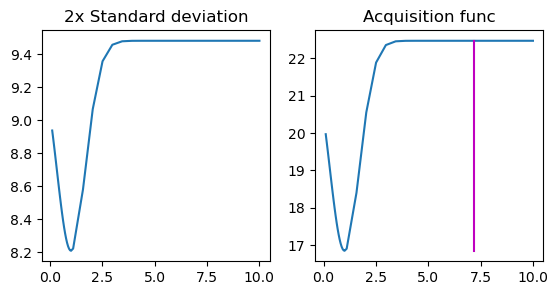

acid_vol 1.755784061696658
base_vol 0.24421593830334198
pH (HH) [3.8833029]
counter value: 1
Acid/Base ratio measured: [7.18947368]
pH Value: [3.8833029]
Optimization restart 1/5, f = 5.7703404504144915
Optimization restart 2/5, f = 5.770340450617326
Optimization restart 3/5, f = 5.770340450852837
Optimization restart 4/5, f = 4.144527199822656
Optimization restart 5/5, f = 5.770340450587195
Variance is [[4.61596801e-04]
 [4.15267816e-04]
 [3.72209755e-04]
 [3.32326789e-04]
 [2.95524129e-04]
 [2.61708025e-04]
 [2.30785768e-04]
 [2.02665700e-04]
 [1.77257215e-04]
 [1.54470762e-04]
 [1.34217853e-04]
 [1.16411061e-04]
 [1.00964032e-04]
 [8.77914803e-05]
 [7.68092000e-05]
 [6.79340637e-05]
 [6.10840288e-05]
 [5.61781405e-05]
 [5.31365354e-05]
 [5.18804456e-05]
 [5.47440937e-05]
 [1.48916371e-04]
 [3.28359056e-04]
 [5.37041227e-04]
 [7.30087249e-04]
 [8.73977830e-04]
 [9.46700240e-04]
 [9.37846985e-04]
 [8.48662459e-04]
 [6.92037367e-04]
 [4.92450939e-04]
 [2.85861205e-04]
 [1.19543856e-04]

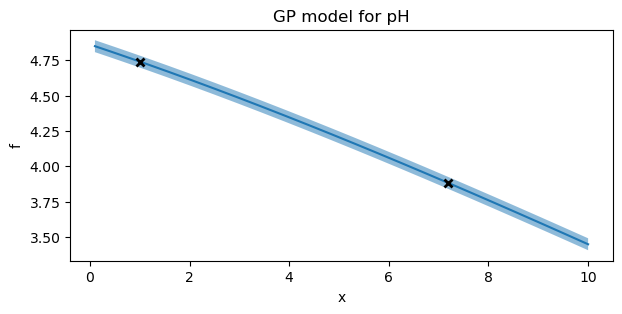

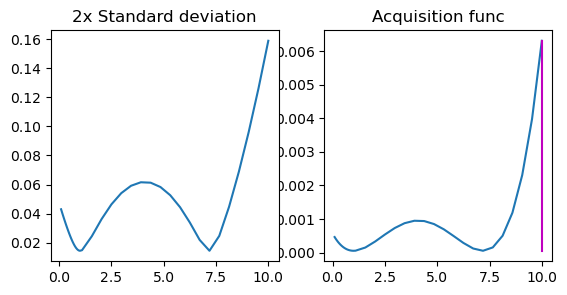

acid_vol 1.8181818181818181
base_vol 0.18181818181818188
pH (HH) [3.74]
counter value: 2
Acid/Base ratio measured: [10.]
pH Value: [3.74]
Optimization restart 1/5, f = 4.068456367775776
Optimization restart 2/5, f = 4.068456367636991
Optimization restart 3/5, f = 4.068456367474962
Optimization restart 4/5, f = 8.52229597643219
Optimization restart 5/5, f = 8.522295977397146
Variance is [[0.04660271]
 [0.04630488]
 [0.04601054]
 [0.04571965]
 [0.04543218]
 [0.04514811]
 [0.04486742]
 [0.04459006]
 [0.04431601]
 [0.04404524]
 [0.04377773]
 [0.04351344]
 [0.04325236]
 [0.04299444]
 [0.04273968]
 [0.04248803]
 [0.04223947]
 [0.04199398]
 [0.04175153]
 [0.0415121 ]
 [0.04101641]
 [0.03886511]
 [0.03697873]
 [0.03533734]
 [0.03392367]
 [0.03272311]
 [0.03172376]
 [0.03091645]
 [0.0302948 ]
 [0.02985515]
 [0.02959665]
 [0.02952122]
 [0.02963356]
 [0.02994113]
 [0.03045413]
 [0.03118552]
 [0.03215092]
 [0.03336864]
 [0.03485961]
 [0.03664732]]
The next ratio to investigate is [0.14736842]
Cdia

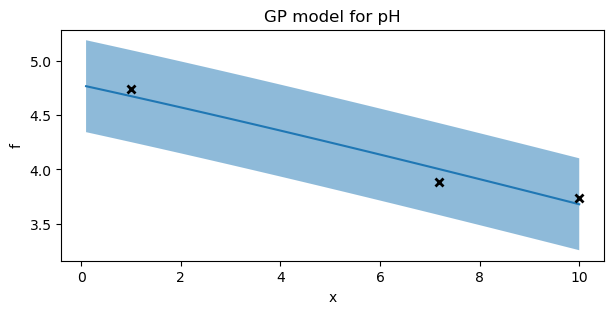

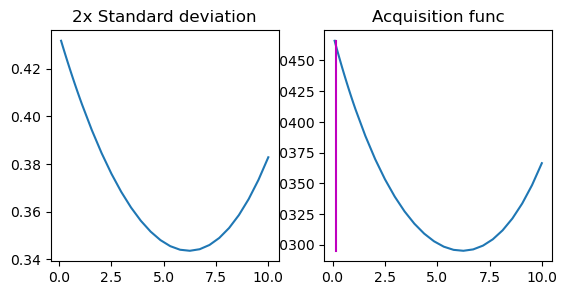

acid_vol 0.25688073394495414
base_vol 1.7431192660550459
pH (HH) [5.57159557]
counter value: 3
Acid/Base ratio measured: [0.14736842]
pH Value: [5.57159557]
Optimization restart 1/5, f = 6.336685451872093
Optimization restart 2/5, f = 11.730650041982205
Optimization restart 3/5, f = 6.336685453640992
Optimization restart 4/5, f = 6.33668545107517
Optimization restart 5/5, f = 6.336685451138189
Variance is [[0.23817956]
 [0.23729323]
 [0.23641938]
 [0.23555792]
 [0.23470875]
 [0.23387179]
 [0.23304695]
 [0.23223415]
 [0.2314333 ]
 [0.23064432]
 [0.22986712]
 [0.22910163]
 [0.22834776]
 [0.22760542]
 [0.22687455]
 [0.22615505]
 [0.22544686]
 [0.22474989]
 [0.22406406]
 [0.22338931]
 [0.22200085]
 [0.21612917]
 [0.21125125]
 [0.20730843]
 [0.20425039]
 [0.20203539]
 [0.20063042]
 [0.20001133]
 [0.20016296]
 [0.20107915]
 [0.20276281]
 [0.20522588]
 [0.20848927]
 [0.21258282]
 [0.21754511]
 [0.22342335]
 [0.23027315]
 [0.23815832]
 [0.24715059]
 [0.25732931]]
The next ratio to investigate 

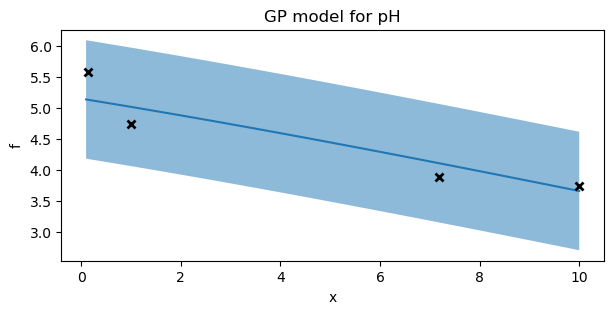

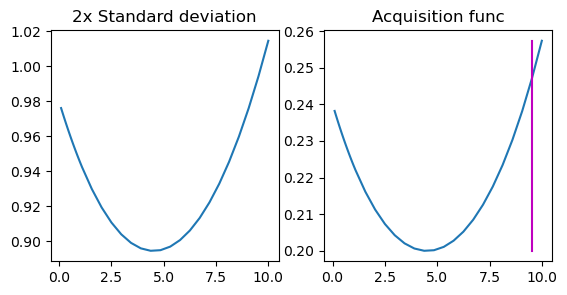

acid_vol 1.8100949525237382
base_vol 0.1899050474762618
pH (HH) [3.76083515]
counter value: 4
Acid/Base ratio measured: [9.53157895]
pH Value: [3.76083515]
Optimization restart 1/5, f = 6.455508660600051
Optimization restart 2/5, f = 6.455508660607754
Optimization restart 3/5, f = 8.206421313284636
Optimization restart 4/5, f = 6.455508660617507
Optimization restart 5/5, f = 6.455508660591952
Variance is [[0.16021948]
 [0.15961644]
 [0.15902162]
 [0.15843494]
 [0.15785631]
 [0.15728565]
 [0.15672288]
 [0.15616791]
 [0.15562067]
 [0.15508106]
 [0.15454903]
 [0.15402447]
 [0.15350732]
 [0.15299749]
 [0.15249492]
 [0.15199952]
 [0.15151121]
 [0.15102993]
 [0.1505556 ]
 [0.15008815]
 [0.14912356]
 [0.14498952]
 [0.14144267]
 [0.13842671]
 [0.13589332]
 [0.13380237]
 [0.13212205]
 [0.130829  ]
 [0.12990836]
 [0.12935388]
 [0.12916788]
 [0.12936131]
 [0.12995365]
 [0.13097287]
 [0.13245533]
 [0.13444564]
 [0.13699653]
 [0.14016859]
 [0.14403014]
 [0.14865693]]
The next ratio to investigate i

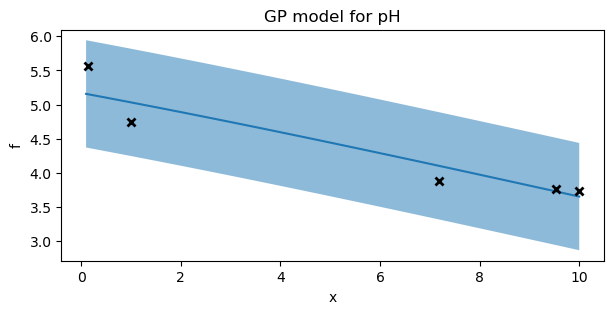

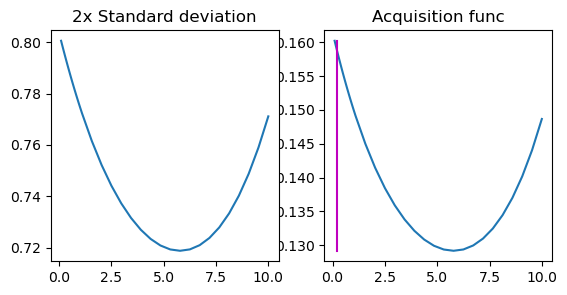

acid_vol 0.3259911894273128
base_vol 1.6740088105726871
pH (HH) [5.45055188]
counter value: 5
Acid/Base ratio measured: [0.19473684]
pH Value: [5.45055188]
Optimization restart 1/5, f = 6.90716010262523
Optimization restart 2/5, f = 6.7169012508969494
Optimization restart 3/5, f = 6.907160101585463
Optimization restart 4/5, f = 6.907160101575128
Optimization restart 5/5, f = 6.907160101586694
Variance is [[0.11928878]
 [0.11893888]
 [0.11859608]
 [0.11826027]
 [0.11793134]
 [0.11760921]
 [0.11729377]
 [0.11698492]
 [0.11668257]
 [0.11638663]
 [0.11609699]
 [0.11581356]
 [0.11553626]
 [0.11526498]
 [0.11499964]
 [0.11474015]
 [0.11448642]
 [0.11423836]
 [0.11399588]
 [0.1137589 ]
 [0.11327627]
 [0.11131367]
 [0.10978799]
 [0.10863298]
 [0.107792  ]
 [0.10721823]
 [0.10687483]
 [0.10673508]
 [0.10678246]
 [0.10701073]
 [0.10742395]
 [0.10803643]
 [0.10887272]
 [0.10996749]
 [0.11136544]
 [0.11312109]
 [0.1152986 ]
 [0.11797158]
 [0.12122275]
 [0.12514369]]
The next ratio to investigate i

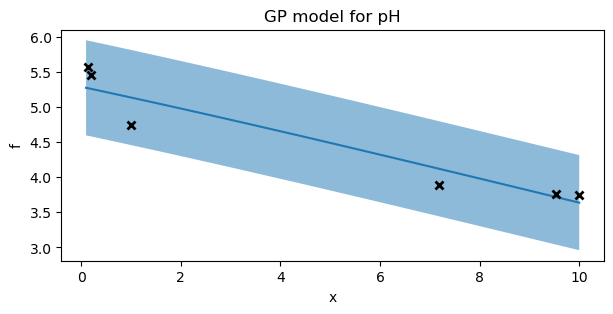

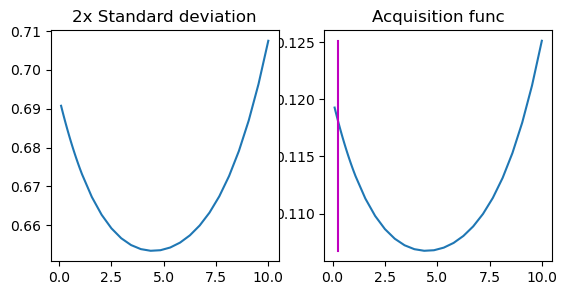

acid_vol 0.38983050847457623
base_vol 1.6101694915254239
pH (HH) [5.35599577]
counter value: 6
Acid/Base ratio measured: [0.24210526]
pH Value: [5.35599577]
Optimization restart 1/5, f = 5.779619864766294
Optimization restart 2/5, f = 6.560393196315783
Optimization restart 3/5, f = 5.779619864707521
Optimization restart 4/5, f = 5.779619864784875
Optimization restart 5/5, f = 5.779619864840317
Variance is [[0.00591405]
 [0.00565451]
 [0.00545524]
 [0.00531153]
 [0.00521904]
 [0.00517381]
 [0.00517223]
 [0.00521105]
 [0.00528729]
 [0.00539831]
 [0.00554173]
 [0.00571545]
 [0.0059176 ]
 [0.00614656]
 [0.0064009 ]
 [0.00667939]
 [0.00698099]
 [0.00730482]
 [0.00765013]
 [0.00801631]
 [0.00885579]
 [0.01393011]
 [0.02078056]
 [0.0289599 ]
 [0.03736118]
 [0.04434497]
 [0.04822875]
 [0.04788448]
 [0.04319143]
 [0.03516433]
 [0.02569709]
 [0.01699331]
 [0.01086174]
 [0.0081089 ]
 [0.0082508 ]
 [0.00969535]
 [0.01043674]
 [0.00918026]
 [0.00670948]
 [0.00724028]]
The next ratio to investigate 

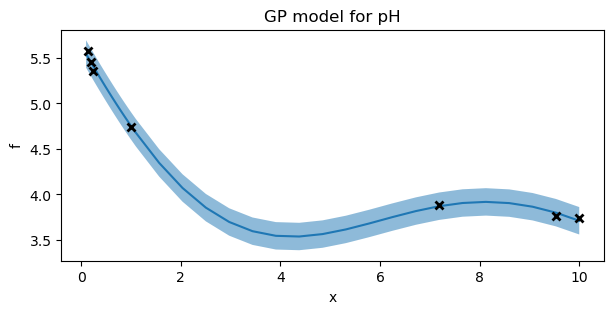

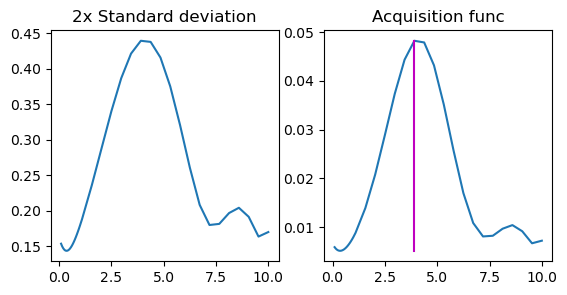

acid_vol 1.5927116827438372
base_vol 0.40728831725616277
pH (HH) [4.14776479]
counter value: 7
Acid/Base ratio measured: [3.91052632]
pH Value: [4.14776479]
Optimization restart 1/5, f = 6.892469267798966
Optimization restart 2/5, f = 6.892469267895073
Optimization restart 3/5, f = 6.892469267798999
Optimization restart 4/5, f = 6.892469268273161
Optimization restart 5/5, f = 6.892469267899897
Variance is [[0.04384886]
 [0.04344717]
 [0.04308233]
 [0.04275289]
 [0.04245743]
 [0.04219455]
 [0.04196292]
 [0.04176119]
 [0.04158809]
 [0.04144235]
 [0.04132274]
 [0.04122806]
 [0.04115716]
 [0.04110889]
 [0.04108214]
 [0.04107585]
 [0.04108896]
 [0.04112046]
 [0.04116935]
 [0.04123468]
 [0.04142241]
 [0.04298786]
 [0.04519169]
 [0.04753525]
 [0.04969521]
 [0.05148248]
 [0.05280391]
 [0.05362864]
 [0.05396127]
 [0.05382329]
 [0.05324369]
 [0.05225944]
 [0.05092566]
 [0.04933489]
 [0.04764443]
 [0.04611001]
 [0.045124  ]
 [0.04525566]
 [0.04729128]
 [0.0522713 ]]
The next ratio to investigate 

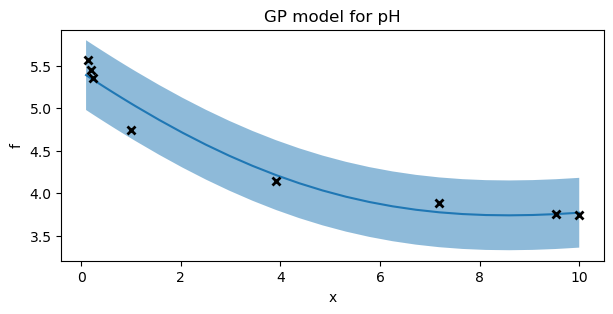

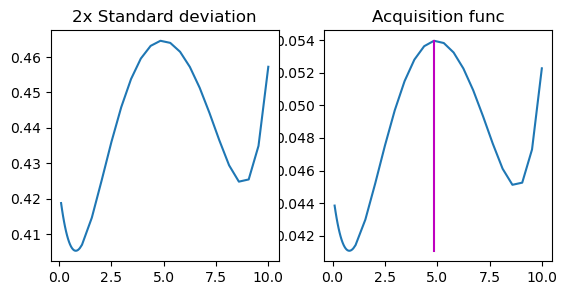

acid_vol 1.657965796579658
base_vol 0.3420342034203421
pH (HH) [4.05449397]
counter value: 8
Acid/Base ratio measured: [4.84736842]
pH Value: [4.05449397]
Optimization restart 1/5, f = 6.306719107278783
Optimization restart 2/5, f = 6.306719107249408
Optimization restart 3/5, f = 6.306719107246805
Optimization restart 4/5, f = 6.306719107247257
Optimization restart 5/5, f = 6.306719107372503
Variance is [[0.03512293]
 [0.03479262]
 [0.03449296]
 [0.03422247]
 [0.03397973]
 [0.03376333]
 [0.03357194]
 [0.03340424]
 [0.03325895]
 [0.03313483]
 [0.0330307 ]
 [0.0329454 ]
 [0.0328778 ]
 [0.03282681]
 [0.0327914 ]
 [0.03277054]
 [0.03276326]
 [0.03276863]
 [0.03278572]
 [0.03281368]
 [0.03290461]
 [0.03372208]
 [0.03478873]
 [0.03575909]
 [0.03647689]
 [0.03691755]
 [0.03713462]
 [0.03721325]
 [0.03723344]
 [0.03724507]
 [0.03725626]
 [0.03723554]
 [0.03712782]
 [0.03688315]
 [0.03649651]
 [0.03605646]
 [0.03579965]
 [0.03616801]
 [0.03786503]
 [0.04190774]]
The next ratio to investigate is

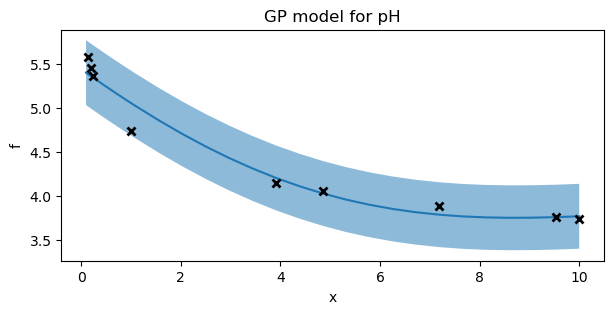

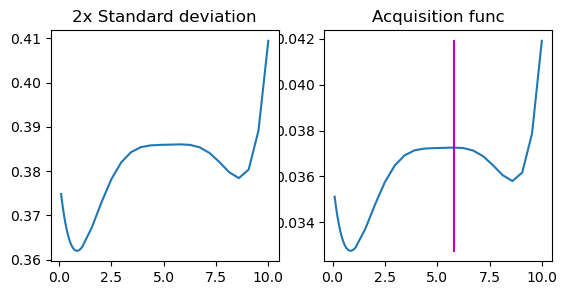

acid_vol 1.7051978277734678
base_vol 0.29480217222653216
pH (HH) [3.97775591]
counter value: 9
Acid/Base ratio measured: [5.78421053]
pH Value: [3.97775591]
Optimization restart 1/5, f = 5.4756335666704095
Optimization restart 2/5, f = 5.475633566675835
Optimization restart 3/5, f = 5.475633566673736
Optimization restart 4/5, f = 5.47563356669302
Optimization restart 5/5, f = 5.475633567086875
Variance is [[0.02174276]
 [0.0213989 ]
 [0.02110591]
 [0.02086063]
 [0.02066002]
 [0.02050112]
 [0.02038109]
 [0.02029719]
 [0.02024674]
 [0.0202272 ]
 [0.0202361 ]
 [0.02027107]
 [0.02032983]
 [0.02041019]
 [0.02051006]
 [0.02062741]
 [0.02076033]
 [0.02090697]
 [0.02106557]
 [0.02123447]
 [0.02161775]
 [0.02355937]
 [0.02508526]
 [0.02574327]
 [0.0254956 ]
 [0.02457015]
 [0.02332668]
 [0.02214397]
 [0.02133237]
 [0.02107446]
 [0.02139544]
 [0.02216378]
 [0.02312206]
 [0.02394695]
 [0.02433671]
 [0.02412308]
 [0.02340342]
 [0.02268687]
 [0.02304658]
 [0.02626829]]
The next ratio to investigate 

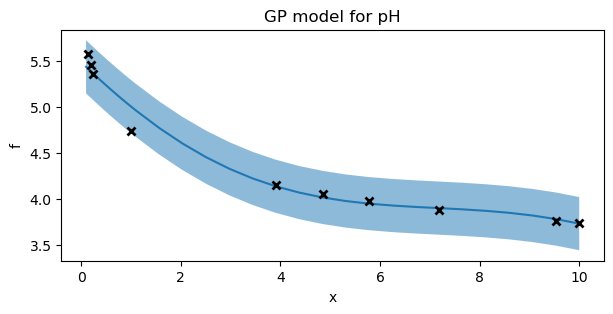

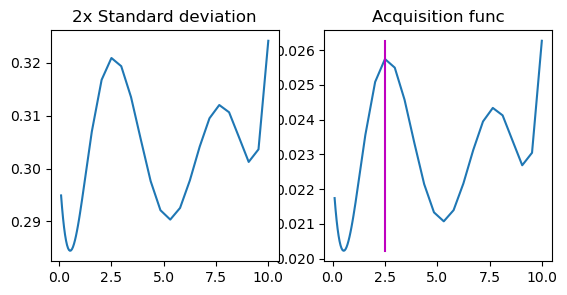

acid_vol 1.4294294294294294
base_vol 0.5705705705705706
pH (HH) [4.34114665]
counter value: 10
Acid/Base ratio measured: [2.50526316]
pH Value: [4.34114665]
Optimization restart 1/5, f = 4.680100795406118
Optimization restart 2/5, f = 4.730390031411595
Optimization restart 3/5, f = 4.730390031390776
Optimization restart 4/5, f = 4.680100795428612
Optimization restart 5/5, f = 4.680100795411789
Variance is [[0.0167068 ]
 [0.01641205]
 [0.01615558]
 [0.01593475]
 [0.01574702]
 [0.01558998]
 [0.01546133]
 [0.01535884]
 [0.01528041]
 [0.01522404]
 [0.0151878 ]
 [0.01516988]
 [0.01516854]
 [0.01518214]
 [0.01520914]
 [0.01524805]
 [0.01529748]
 [0.01535613]
 [0.01542275]
 [0.01549619]
 [0.01566875]
 [0.01657547]
 [0.01725518]
 [0.01748905]
 [0.01730759]
 [0.0168661 ]
 [0.01635866]
 [0.01596394]
 [0.015814  ]
 [0.0159775 ]
 [0.01645082]
 [0.01715493]
 [0.01794002]
 [0.01860413]
 [0.01893477]
 [0.01878319]
 [0.01817899]
 [0.01748856]
 [0.01761469]
 [0.02022698]]
The next ratio to investigate 

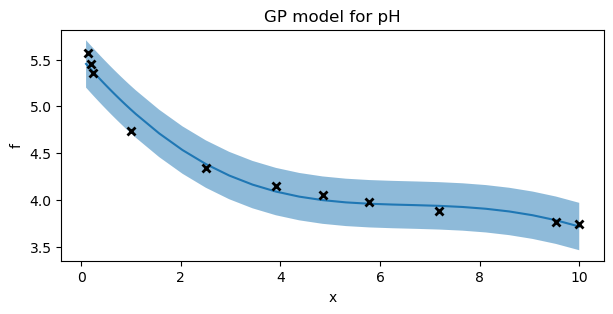

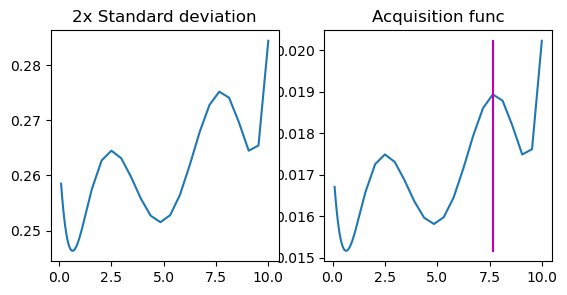

acid_vol 1.7689969604863223
base_vol 0.23100303951367773
pH (HH) [3.85589061]
counter value: 11
Acid/Base ratio measured: [7.65789474]
pH Value: [3.85589061]
Optimization restart 1/5, f = 3.368228583603539
Optimization restart 2/5, f = 3.719604916016123
Optimization restart 3/5, f = 3.3682285835960784
Optimization restart 4/5, f = 3.368228583598441
Optimization restart 5/5, f = 3.71960491613042
Variance is [[0.00688237]
 [0.00665197]
 [0.00647197]
 [0.00633682]
 [0.00624135]
 [0.00618077]
 [0.00615066]
 [0.00614691]
 [0.00616577]
 [0.00620379]
 [0.00625779]
 [0.00632491]
 [0.00640251]
 [0.00648823]
 [0.00657994]
 [0.00667572]
 [0.00677387]
 [0.00687288]
 [0.00697142]
 [0.00706832]
 [0.00726319]
 [0.00786387]
 [0.00789896]
 [0.00759135]
 [0.00721372]
 [0.00693166]
 [0.00679153]
 [0.00676107]
 [0.00677412]
 [0.00676745]
 [0.00671292]
 [0.0066426 ]
 [0.00664936]
 [0.0068415 ]
 [0.00724932]
 [0.00772654]
 [0.00794462]
 [0.00761901]
 [0.00710376]
 [0.00842969]]
The next ratio to investigate

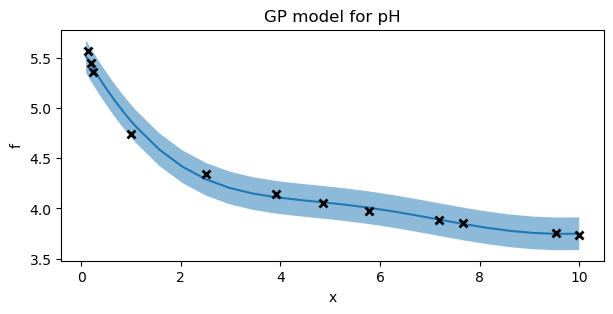

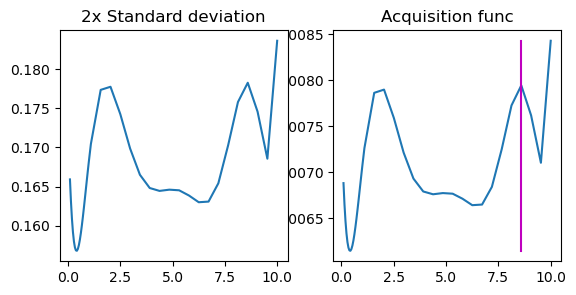

acid_vol 1.7915523861766318
base_vol 0.20844761382336818
pH (HH) [3.80576742]
counter value: 12
Acid/Base ratio measured: [8.59473684]
pH Value: [3.80576742]
Optimization restart 1/5, f = 1.8195415387299416
Optimization restart 2/5, f = 1.819541538476738
Optimization restart 3/5, f = 1.8195415384785223
Optimization restart 4/5, f = 1.819541538473631
Optimization restart 5/5, f = 1.8195415384786866
Variance is [[0.00437419]
 [0.00418414]
 [0.00404444]
 [0.00394839]
 [0.00388984]
 [0.00386322]
 [0.00386344]
 [0.00388592]
 [0.00392653]
 [0.00398157]
 [0.00404775]
 [0.00412214]
 [0.00420216]
 [0.00428558]
 [0.00437045]
 [0.0044551 ]
 [0.00453812]
 [0.00461832]
 [0.00469475]
 [0.00476663]
 [0.00490091]
 [0.00518144]
 [0.00505204]
 [0.0048242 ]
 [0.00465187]
 [0.00452818]
 [0.00441067]
 [0.00430437]
 [0.00425318]
 [0.00427958]
 [0.00434339]
 [0.00436371]
 [0.00429228]
 [0.00417653]
 [0.00414198]
 [0.0042721 ]
 [0.00446351]
 [0.00445012]
 [0.00426653]
 [0.0054025 ]]
The next ratio to investig

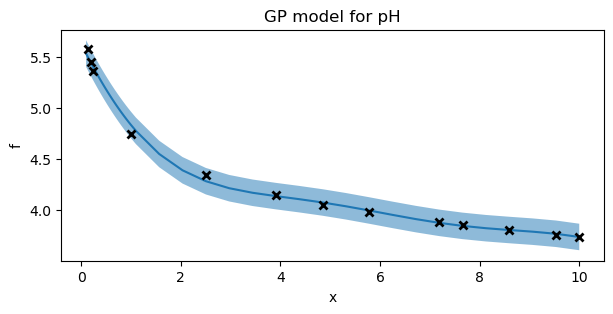

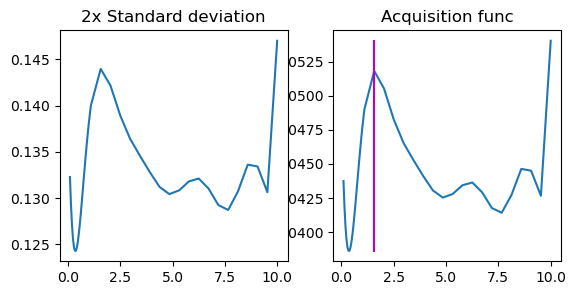

acid_vol 1.221311475409836
base_vol 0.778688524590164
pH (HH) [4.54453734]
counter value: 13
Acid/Base ratio measured: [1.56842105]
pH Value: [4.54453734]
Optimization restart 1/5, f = 0.050914395111220756
Optimization restart 2/5, f = 0.05091439511283902
Optimization restart 3/5, f = 0.050914395138409674
Optimization restart 4/5, f = 3.463435598178382
Optimization restart 5/5, f = 0.050914397715993154
Variance is [[0.00349913]
 [0.00335247]
 [0.00324095]
 [0.00315943]
 [0.00310327]
 [0.00306832]
 [0.00305087]
 [0.00304764]
 [0.00305572]
 [0.00307258]
 [0.003096  ]
 [0.00312408]
 [0.00315517]
 [0.00318792]
 [0.00322117]
 [0.00325399]
 [0.00328562]
 [0.00331548]
 [0.00334314]
 [0.00336828]
 [0.00341237]
 [0.00347624]
 [0.00345998]
 [0.00350917]
 [0.0035972 ]
 [0.00362886]
 [0.00356681]
 [0.00346359]
 [0.00340479]
 [0.00343088]
 [0.00350289]
 [0.00353623]
 [0.00347775]
 [0.00336709]
 [0.00332289]
 [0.00343415]
 [0.00361997]
 [0.00362873]
 [0.00344119]
 [0.00436112]]
The next ratio to inv

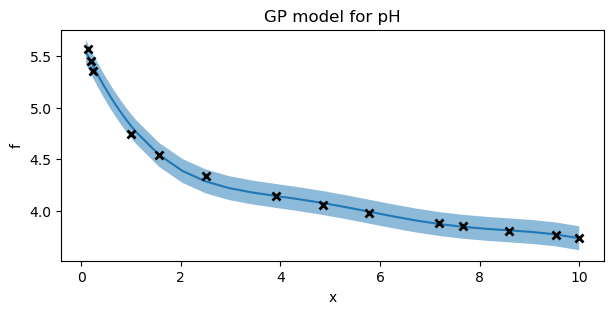

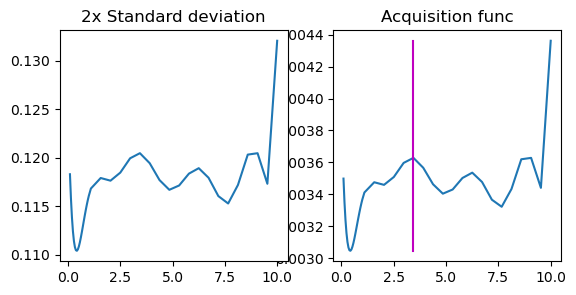

acid_vol 1.5497630331753554
base_vol 0.45023696682464465
pH (HH) [4.20317585]
counter value: 14
Acid/Base ratio measured: [3.44210526]
pH Value: [4.20317585]
Optimization restart 1/5, f = -1.8246300131325306
Optimization restart 2/5, f = -1.8246300131163071
Optimization restart 3/5, f = -1.8246300131122002
Optimization restart 4/5, f = -1.8246300131384867
Optimization restart 5/5, f = -1.8246300131040698
Variance is [[0.00277777]
 [0.00265188]
 [0.00255792]
 [0.00249096]
 [0.0024466 ]
 [0.00242093]
 [0.00241047]
 [0.00241218]
 [0.00242338]
 [0.00244175]
 [0.00246529]
 [0.0024923 ]
 [0.00252133]
 [0.00255117]
 [0.00258084]
 [0.00260954]
 [0.00263665]
 [0.00266169]
 [0.0026843 ]
 [0.00270427]
 [0.00273725]
 [0.00274971]
 [0.00266729]
 [0.00261762]
 [0.00260311]
 [0.0025879 ]
 [0.00256911]
 [0.00257558]
 [0.00262953]
 [0.00271882]
 [0.00279917]
 [0.00282075]
 [0.00276456]
 [0.00267053]
 [0.00263099]
 [0.00272266]
 [0.00289283]
 [0.0029231 ]
 [0.00274312]
 [0.00347172]]
The next ratio to i

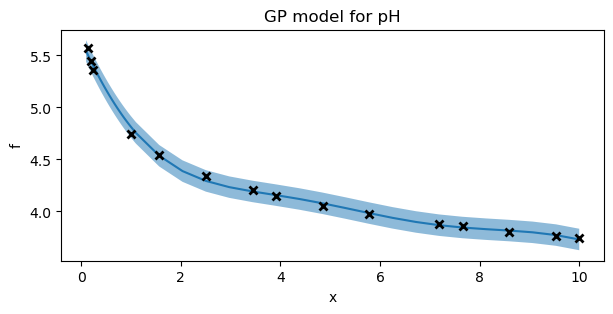

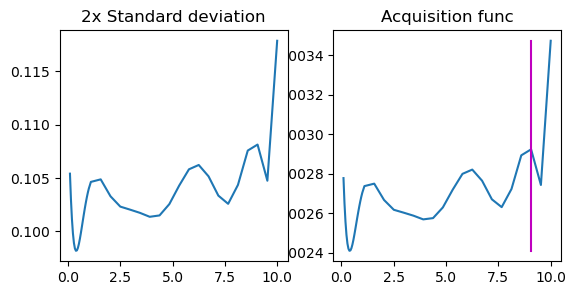

acid_vol 1.8012552301255231
base_vol 0.19874476987447687
pH (HH) [3.78272045]
counter value: 15
Acid/Base ratio measured: [9.06315789]
pH Value: [3.78272045]
Optimization restart 1/5, f = -3.8181233862015205
Optimization restart 2/5, f = -3.8181233861967527
Optimization restart 3/5, f = -3.8181233861646504
Optimization restart 4/5, f = -3.818123386218339
Optimization restart 5/5, f = -3.8181233861890043
Variance is [[0.00202385]
 [0.00191724]
 [0.00184168]
 [0.00179172]
 [0.00176256]
 [0.00175   ]
 [0.00175042]
 [0.00176066]
 [0.00177807]
 [0.00180037]
 [0.00182567]
 [0.00185244]
 [0.0018794 ]
 [0.00190556]
 [0.00193017]
 [0.00195266]
 [0.00197264]
 [0.00198987]
 [0.00200424]
 [0.00201574]
 [0.00203098]
 [0.00199683]
 [0.00194365]
 [0.00193767]
 [0.00192843]
 [0.00189156]
 [0.00186286]
 [0.00188131]
 [0.00194193]
 [0.0020066 ]
 [0.00204384]
 [0.00204725]
 [0.00202169]
 [0.00196968]
 [0.00190546]
 [0.00187071]
 [0.00189306]
 [0.00190484]
 [0.00185798]
 [0.00254281]]
The next ratio to in

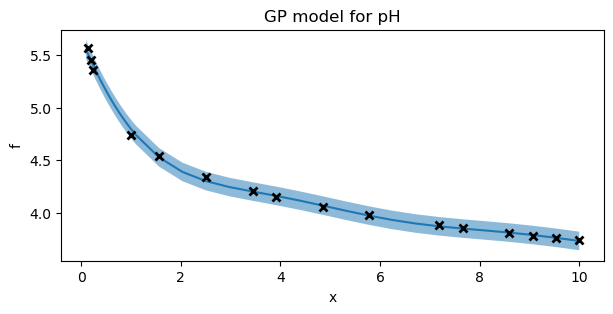

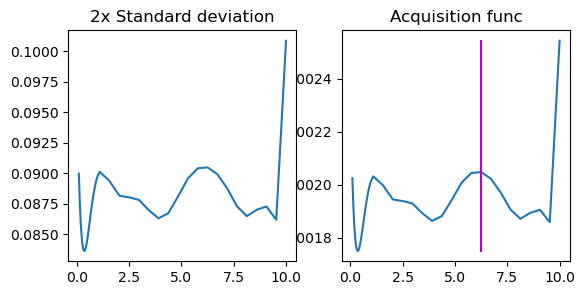

acid_vol 1.7242380261248187
base_vol 0.2757619738751813
pH (HH) [3.94393716]
counter value: 16
Acid/Base ratio measured: [6.25263158]
pH Value: [3.94393716]
Optimization restart 1/5, f = -6.006976709967121
Optimization restart 2/5, f = -6.0069767099577405
Optimization restart 3/5, f = -6.006976709993115
Optimization restart 4/5, f = -6.006976709970358
Optimization restart 5/5, f = -6.006976709953223
Variance is [[0.00165646]
 [0.00156261]
 [0.00149788]
 [0.00145682]
 [0.00143471]
 [0.00142744]
 [0.00143151]
 [0.00144391]
 [0.00146211]
 [0.00148403]
 [0.00150794]
 [0.00153245]
 [0.00155648]
 [0.00157918]
 [0.00159994]
 [0.00161835]
 [0.00163413]
 [0.00164718]
 [0.00165748]
 [0.00166509]
 [0.0016731 ]
 [0.00162924]
 [0.001592  ]
 [0.00159508]
 [0.00158239]
 [0.00154456]
 [0.00152107]
 [0.00153284]
 [0.00155474]
 [0.00155148]
 [0.00152222]
 [0.00149971]
 [0.00150753]
 [0.00152967]
 [0.00153473]
 [0.00152749]
 [0.001543  ]
 [0.00155663]
 [0.0015198 ]
 [0.00208095]]
The next ratio to invest

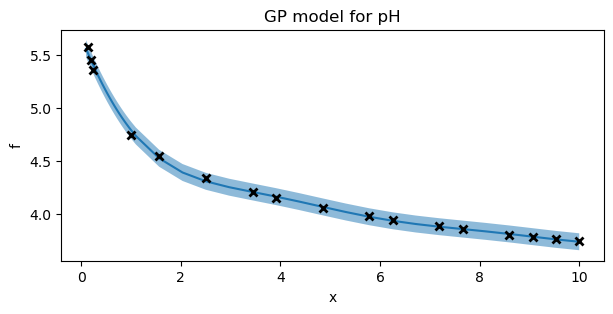

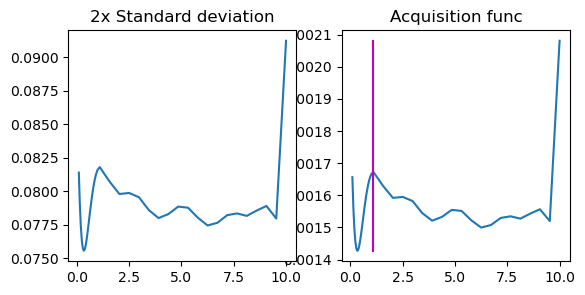

acid_vol 1.0476190476190477
base_vol 0.9523809523809523
pH (HH) [4.69860731]
counter value: 17
Acid/Base ratio measured: [1.1]
pH Value: [4.69860731]
Optimization restart 1/5, f = -8.028472549829122
Optimization restart 2/5, f = -8.028472549805013
Optimization restart 3/5, f = -8.028472549759176
Optimization restart 4/5, f = -8.028472549782432
Optimization restart 5/5, f = -8.028472549763354
Variance is [[0.0013237 ]
 [0.00124369]
 [0.00118792]
 [0.00115136]
 [0.00112973]
 [0.00111942]
 [0.00111741]
 [0.00112123]
 [0.00112885]
 [0.00113867]
 [0.00114943]
 [0.00116018]
 [0.00117025]
 [0.00117917]
 [0.00118665]
 [0.00119257]
 [0.00119691]
 [0.00119974]
 [0.00120121]
 [0.00120153]
 [0.0011994 ]
 [0.00119379]
 [0.00124887]
 [0.00129703]
 [0.00127934]
 [0.00123248]
 [0.00121562]
 [0.00123612]
 [0.00125756]
 [0.00125071]
 [0.00122212]
 [0.00120135]
 [0.00120818]
 [0.00123091]
 [0.00123937]
 [0.00122816]
 [0.00123196]
 [0.00125038]
 [0.0012222 ]
 [0.00166863]]
The next ratio to investigate is

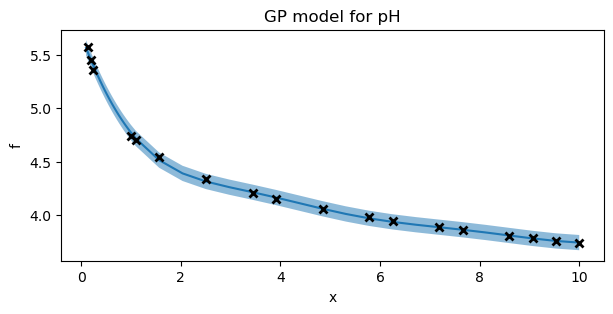

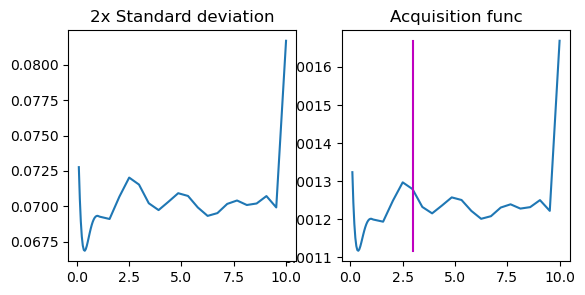

acid_vol 1.4966887417218544
base_vol 0.5033112582781456
pH (HH) [4.26670515]
counter value: 18
Acid/Base ratio measured: [2.97368421]
pH Value: [4.26670515]
Optimization restart 1/5, f = -10.475505837330997
Optimization restart 2/5, f = -10.475505837365347
Optimization restart 3/5, f = -10.475505837350358
Optimization restart 4/5, f = -10.47550583729388
Optimization restart 5/5, f = -10.47550583734533
Variance is [[0.00111793]
 [0.00104661]
 [0.00099792]
 [0.00096694]
 [0.00094955]
 [0.00094227]
 [0.00094226]
 [0.00094717]
 [0.00095516]
 [0.00096476]
 [0.00097485]
 [0.00098461]
 [0.00099347]
 [0.00100106]
 [0.00100717]
 [0.00101173]
 [0.00101479]
 [0.00101643]
 [0.00101683]
 [0.00101619]
 [0.00101239]
 [0.00099659]
 [0.00101639]
 [0.00101636]
 [0.00098278]
 [0.00096815]
 [0.00099939]
 [0.00104558]
 [0.00106641]
 [0.00105497]
 [0.00103115]
 [0.00101631]
 [0.0010209 ]
 [0.00103952]
 [0.0010508 ]
 [0.0010422 ]
 [0.00103925]
 [0.00105605]
 [0.00103616]
 [0.00140895]]
The next ratio to inve

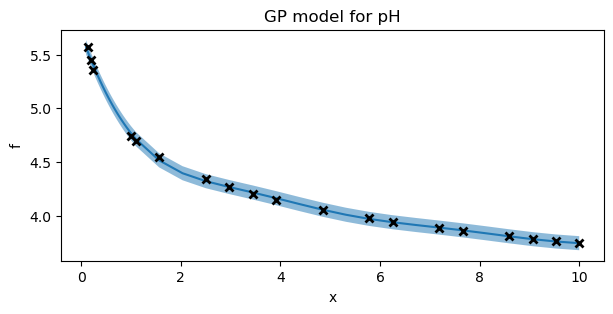

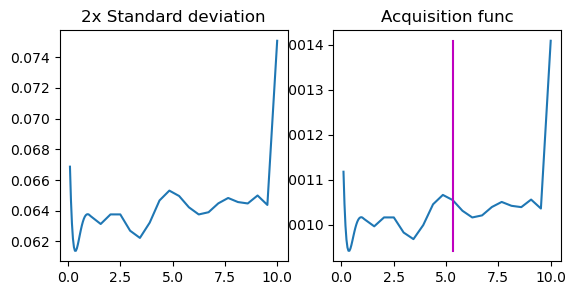

acid_vol 1.6833333333333333
base_vol 0.31666666666666665
pH (HH) [4.01443223]
counter value: 19
Acid/Base ratio measured: [5.31578947]
pH Value: [4.01443223]
Optimization restart 1/5, f = -12.986503134729498
Optimization restart 2/5, f = -12.98650313463774
Optimization restart 3/5, f = -12.986503126025022
Optimization restart 4/5, f = -12.986503134693672
Optimization restart 5/5, f = -12.986503134717378
Variance is [[0.00098345]
 [0.00091787]
 [0.00087401]
 [0.00084699]
 [0.00083269]
 [0.00082772]
 [0.00082928]
 [0.00083512]
 [0.00084346]
 [0.00085295]
 [0.00086254]
 [0.0008715 ]
 [0.00087935]
 [0.00088578]
 [0.00089066]
 [0.00089399]
 [0.00089584]
 [0.00089636]
 [0.00089576]
 [0.00089425]
 [0.00088916]
 [0.00087536]
 [0.00089803]
 [0.00089529]
 [0.0008618 ]
 [0.00084916]
 [0.00086886]
 [0.00088318]
 [0.00086997]
 [0.00084955]
 [0.00084838]
 [0.00086697]
 [0.00089152]
 [0.0009134 ]
 [0.00092401]
 [0.00091671]
 [0.00091209]
 [0.00092793]
 [0.00091297]
 [0.00123808]]
The next ratio to in

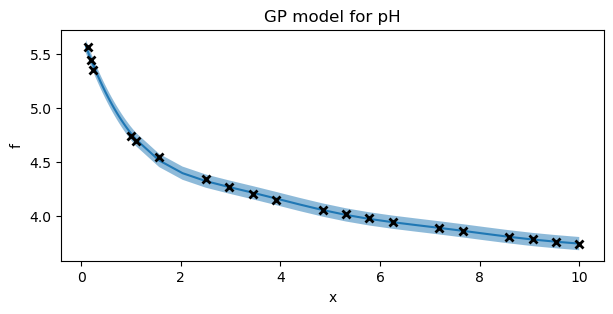

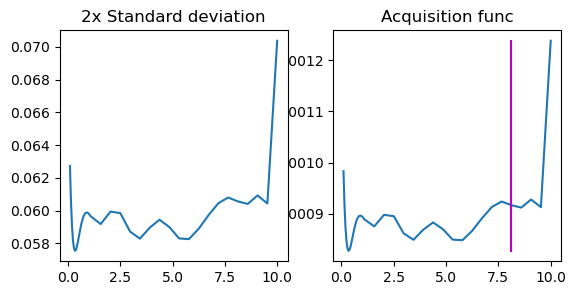

acid_vol 1.7808535178777394
base_vol 0.21914648212226062
pH (HH) [3.8301063]
counter value: 20
Acid/Base ratio measured: [8.12631579]
pH Value: [3.8301063]
Optimization restart 1/5, f = -15.598973792007502
Optimization restart 2/5, f = -15.598973792707278
Optimization restart 3/5, f = -15.598973793118484
Optimization restart 4/5, f = -15.598973793045008
Optimization restart 5/5, f = -15.59897379301282
Variance is [[0.0008583 ]
 [0.00079771]
 [0.00075825]
 [0.00073496]
 [0.00072371]
 [0.0007211 ]
 [0.00072436]
 [0.00073129]
 [0.00074018]
 [0.00074973]
 [0.00075898]
 [0.00076728]
 [0.00077421]
 [0.00077954]
 [0.00078322]
 [0.00078528]
 [0.00078588]
 [0.00078521]
 [0.0007835 ]
 [0.00078102]
 [0.00077437]
 [0.00076243]
 [0.00079068]
 [0.00078662]
 [0.00074994]
 [0.00073853]
 [0.00076138]
 [0.00077544]
 [0.00075879]
 [0.00073704]
 [0.00073892]
 [0.00075855]
 [0.00077199]
 [0.0007688 ]
 [0.00075319]
 [0.00073653]
 [0.00074705]
 [0.00079385]
 [0.0007992 ]
 [0.00107637]]
The next ratio to inve

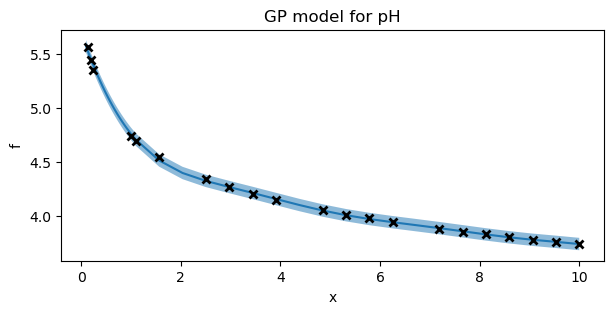

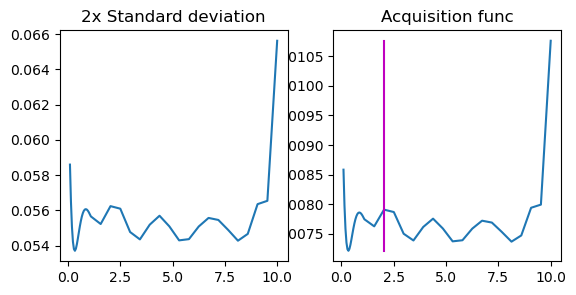

acid_vol 1.341421143847487
base_vol 0.658578856152513
pH (HH) [4.43104264]
counter value: 21
Acid/Base ratio measured: [2.03684211]
pH Value: [4.43104264]
Optimization restart 1/5, f = -17.725779316858848
Optimization restart 2/5, f = -17.72577931687256
Optimization restart 3/5, f = -17.72577931690944
Optimization restart 4/5, f = -17.725779316965316
Optimization restart 5/5, f = -17.725779314047223
Variance is [[0.00075366]
 [0.00069514]
 [0.00065846]
 [0.00063824]
 [0.00063008]
 [0.00063033]
 [0.0006361 ]
 [0.00064508]
 [0.00065551]
 [0.00066604]
 [0.00067574]
 [0.00068397]
 [0.00069034]
 [0.00069468]
 [0.00069696]
 [0.00069729]
 [0.00069585]
 [0.00069289]
 [0.0006887 ]
 [0.00068356]
 [0.00067094]
 [0.0006309 ]
 [0.0006435 ]
 [0.0006473 ]
 [0.00063548]
 [0.00064434]
 [0.0006712 ]
 [0.00068076]
 [0.0006622 ]
 [0.00064272]
 [0.00064719]
 [0.00066708]
 [0.00067804]
 [0.00067262]
 [0.00065936]
 [0.00064597]
 [0.00065204]
 [0.00069509]
 [0.0007053 ]
 [0.00094138]]
The next ratio to invest

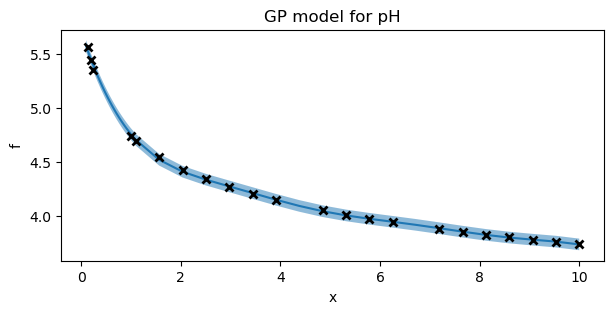

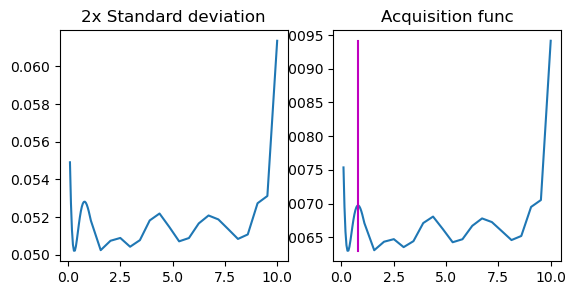

acid_vol 0.8953488372093024
base_vol 1.1046511627906976
pH (HH) [4.83123288]
counter value: 22
Acid/Base ratio measured: [0.81052632]
pH Value: [4.83123288]
Optimization restart 1/5, f = -18.89068919746359
Optimization restart 2/5, f = -18.89068919473424
Optimization restart 3/5, f = -18.89068919743109
Optimization restart 4/5, f = -18.890689197296187
Optimization restart 5/5, f = -18.89068919732433
Variance is [[0.00071682]
 [0.00065723]
 [0.00061876]
 [0.00059598]
 [0.00058452]
 [0.00058084]
 [0.00058219]
 [0.00058644]
 [0.00059202]
 [0.00059778]
 [0.00060295]
 [0.00060705]
 [0.00060983]
 [0.00061122]
 [0.00061129]
 [0.00061017]
 [0.00060809]
 [0.00060529]
 [0.00060201]
 [0.00059851]
 [0.00059137]
 [0.00058981]
 [0.00061588]
 [0.00061224]
 [0.00059987]
 [0.00061312]
 [0.00064006]
 [0.00064892]
 [0.00063114]
 [0.00061027]
 [0.00061369]
 [0.00063739]
 [0.00065085]
 [0.00064089]
 [0.00062502]
 [0.00061555]
 [0.00061921]
 [0.00065901]
 [0.00067729]
 [0.00089243]]
The next ratio to invest

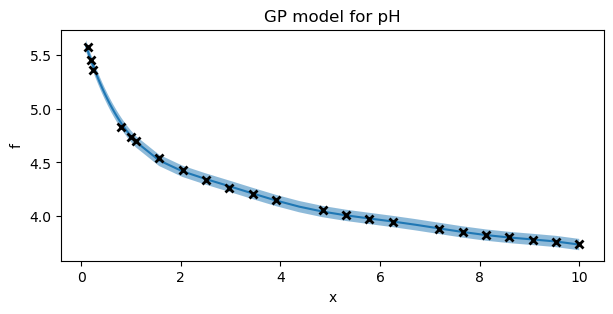

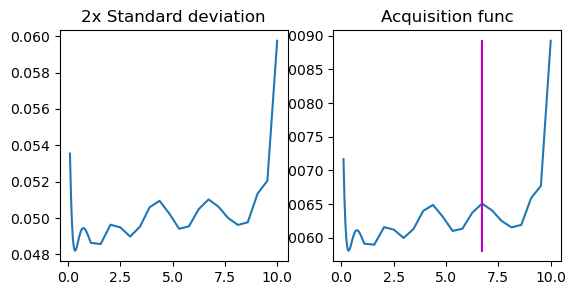

acid_vol 1.7409679618268576
base_vol 0.25903203817314235
pH (HH) [3.9125627]
counter value: 23
Acid/Base ratio measured: [6.72105263]
pH Value: [3.9125627]
Optimization restart 1/5, f = -21.63032242819628
Optimization restart 2/5, f = -21.630322428305547
Optimization restart 3/5, f = -21.630322428151402
Optimization restart 4/5, f = -21.630322428351775
Optimization restart 5/5, f = -21.63032242832064
Variance is [[0.00061658]
 [0.00056139]
 [0.000527  ]
 [0.0005078 ]
 [0.00049927]
 [0.00049784]
 [0.00050076]
 [0.00050595]
 [0.0005119 ]
 [0.00051758]
 [0.0005223 ]
 [0.0005257 ]
 [0.00052761]
 [0.00052806]
 [0.00052719]
 [0.0005252 ]
 [0.00052235]
 [0.00051894]
 [0.00051522]
 [0.00051146]
 [0.00050435]
 [0.00050721]
 [0.00053094]
 [0.00052347]
 [0.00051364]
 [0.00052683]
 [0.00054752]
 [0.00055445]
 [0.0005428 ]
 [0.00052314]
 [0.00051182]
 [0.00051304]
 [0.0005154 ]
 [0.00051538]
 [0.00052235]
 [0.00052929]
 [0.00053017]
 [0.00056224]
 [0.00058691]
 [0.00076351]]
The next ratio to inves

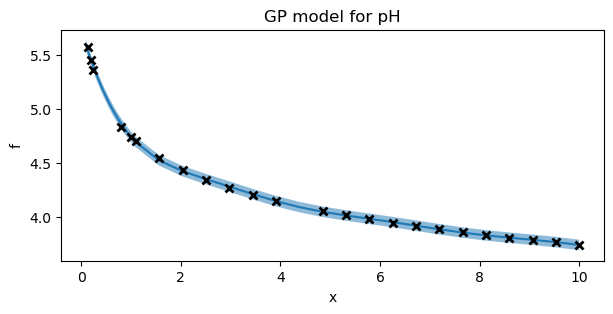

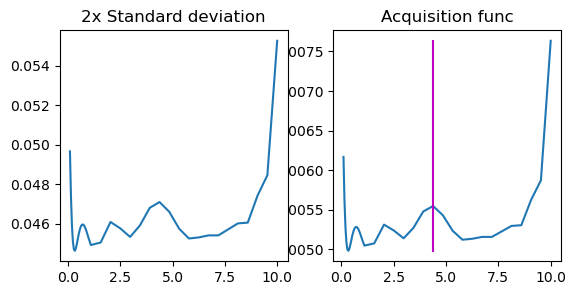

acid_vol 1.6281800391389432
base_vol 0.37181996086105684
pH (HH) [4.09863027]
counter value: 24
Acid/Base ratio measured: [4.37894737]
pH Value: [4.09863027]
Optimization restart 1/5, f = -24.39277790303219
Optimization restart 2/5, f = -24.392777903070538
Optimization restart 3/5, f = -24.39277790306197
Optimization restart 4/5, f = -24.392777902993032
Optimization restart 5/5, f = -24.392777902862996
Variance is [[0.00055745]
 [0.0005056 ]
 [0.00047392]
 [0.00045681]
 [0.00044978]
 [0.00044934]
 [0.00045281]
 [0.00045819]
 [0.00046405]
 [0.00046943]
 [0.00047373]
 [0.00047663]
 [0.00047804]
 [0.00047802]
 [0.00047675]
 [0.00047444]
 [0.00047139]
 [0.00046786]
 [0.00046414]
 [0.00046046]
 [0.00045377]
 [0.00045796]
 [0.00047822]
 [0.00047098]
 [0.00046243]
 [0.00046383]
 [0.0004629 ]
 [0.00045993]
 [0.00046029]
 [0.00046071]
 [0.0004603 ]
 [0.00046243]
 [0.00046406]
 [0.00046425]
 [0.00047085]
 [0.00047807]
 [0.0004783 ]
 [0.00050667]
 [0.00053235]
 [0.00068831]]
The next ratio to inv

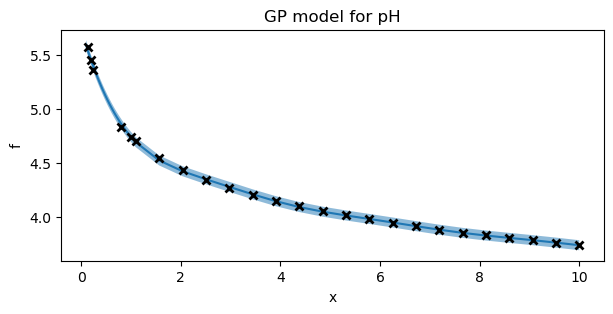

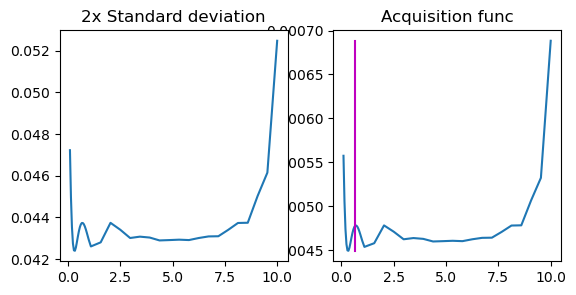

acid_vol 0.8012618296529967
base_vol 1.1987381703470033
pH (HH) [4.91494988]
counter value: 25
Acid/Base ratio measured: [0.66842105]
pH Value: [4.91494988]
Optimization restart 1/5, f = -25.326940778235183
Optimization restart 2/5, f = -25.32694077818862
Optimization restart 3/5, f = -25.326940778441838
Optimization restart 4/5, f = -25.326940778072114
Optimization restart 5/5, f = -25.326940778242296
Variance is [[0.00052176]
 [0.00046694]
 [0.00043349]
 [0.00041505]
 [0.00040671]
 [0.00040474]
 [0.00040637]
 [0.00040963]
 [0.00041319]
 [0.00041622]
 [0.00041827]
 [0.00041917]
 [0.00041895]
 [0.00041777]
 [0.00041588]
 [0.00041355]
 [0.00041107]
 [0.00040868]
 [0.00040662]
 [0.00040505]
 [0.00040391]
 [0.00043056]
 [0.00044558]
 [0.0004344 ]
 [0.0004316 ]
 [0.00043315]
 [0.00042974]
 [0.00042797]
 [0.00042955]
 [0.00042942]
 [0.00042821]
 [0.00043033]
 [0.0004333 ]
 [0.00043281]
 [0.00043679]
 [0.00044676]
 [0.00044695]
 [0.00046847]
 [0.00050472]
 [0.00063657]]
The next ratio to inv

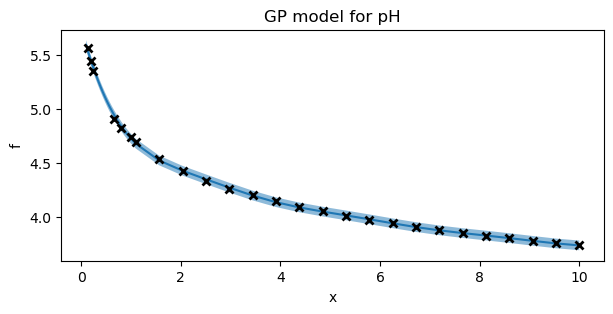

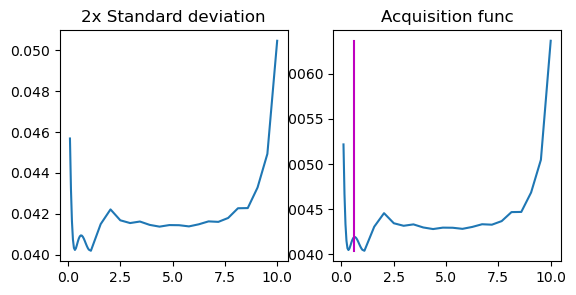

acid_vol 0.7662337662337663
base_vol 1.2337662337662336
pH (HH) [4.94687159]
counter value: 26
Acid/Base ratio measured: [0.62105263]
pH Value: [4.94687159]
Optimization restart 1/5, f = -26.961668787531778
Optimization restart 2/5, f = -26.96166878757198
Optimization restart 3/5, f = -26.96166878727972
Optimization restart 4/5, f = -26.96166878755875
Optimization restart 5/5, f = -26.96166878460825
Variance is [[0.00045336]
 [0.00039918]
 [0.00036675]
 [0.00034914]
 [0.00034111]
 [0.00033881]
 [0.00033952]
 [0.0003414 ]
 [0.00034331]
 [0.00034461]
 [0.00034503]
 [0.00034456]
 [0.00034338]
 [0.00034172]
 [0.00033987]
 [0.00033811]
 [0.0003367 ]
 [0.00033582]
 [0.00033562]
 [0.00033618]
 [0.00033989]
 [0.00037608]
 [0.00038109]
 [0.0003732 ]
 [0.00037435]
 [0.00037206]
 [0.00036996]
 [0.00037062]
 [0.00036962]
 [0.00036974]
 [0.00037078]
 [0.00037042]
 [0.0003729 ]
 [0.00037517]
 [0.00037549]
 [0.00038462]
 [0.00038863]
 [0.00040007]
 [0.00044414]
 [0.0005436 ]]
The next ratio to invest

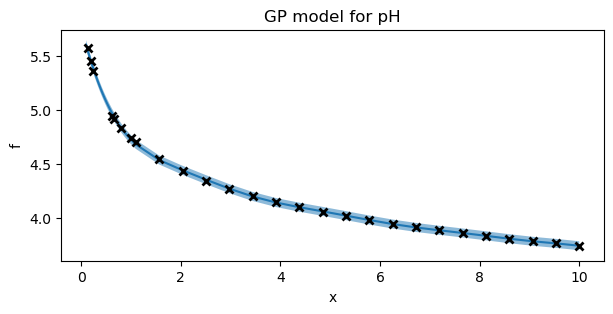

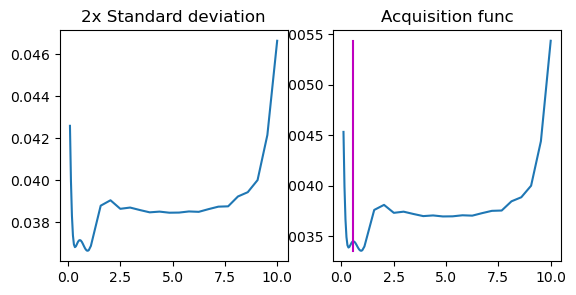

acid_vol 0.7290969899665551
base_vol 1.2709030100334449
pH (HH) [4.9813271]
counter value: 27
Acid/Base ratio measured: [0.57368421]
pH Value: [4.9813271]
Optimization restart 1/5, f = -28.874401521510187
Optimization restart 2/5, f = -28.87440152141466
Optimization restart 3/5, f = -28.87440152147297
Optimization restart 4/5, f = -28.874401521418328
Optimization restart 5/5, f = -28.874401521409787
Variance is [[0.00041154]
 [0.00035847]
 [0.00032675]
 [0.00030932]
 [0.00030095]
 [0.0002979 ]
 [0.00029758]
 [0.00029832]
 [0.00029913]
 [0.00029949]
 [0.00029925]
 [0.00029846]
 [0.00029731]
 [0.00029606]
 [0.00029496]
 [0.00029424]
 [0.00029407]
 [0.0002946 ]
 [0.00029587]
 [0.00029788]
 [0.0003043 ]
 [0.00034055]
 [0.00034119]
 [0.0003371 ]
 [0.00033801]
 [0.00033477]
 [0.00033402]
 [0.00033459]
 [0.00033317]
 [0.00033349]
 [0.00033483]
 [0.00033422]
 [0.00033593]
 [0.00033914]
 [0.00033881]
 [0.00034614]
 [0.00035259]
 [0.00035912]
 [0.00040577]
 [0.00048734]]
The next ratio to invest

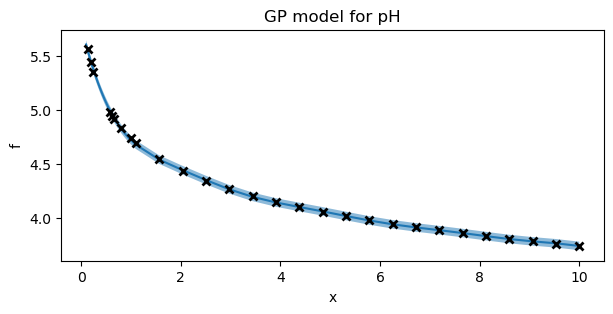

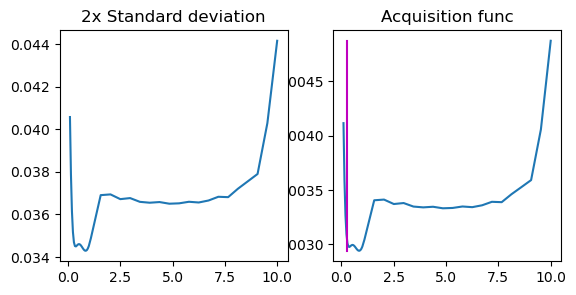

acid_vol 0.4489795918367347
base_vol 1.5510204081632653
pH (HH) [5.27839091]
counter value: 28
Acid/Base ratio measured: [0.28947368]
pH Value: [5.27839091]
Optimization restart 1/5, f = -29.51690377793365
Optimization restart 2/5, f = -29.516903778738453
Optimization restart 3/5, f = -29.5169037788079
Optimization restart 4/5, f = -29.51690377882801
Optimization restart 5/5, f = -29.516903778595648
Variance is [[0.00052496]
 [0.00046066]
 [0.00042148]
 [0.00039954]
 [0.00038888]
 [0.00038514]
 [0.00038522]
 [0.00038704]
 [0.00038927]
 [0.00039116]
 [0.0003924 ]
 [0.00039293]
 [0.00039288]
 [0.00039249]
 [0.00039203]
 [0.00039177]
 [0.00039193]
 [0.00039269]
 [0.00039416]
 [0.0003964 ]
 [0.00040354]
 [0.00044867]
 [0.0004532 ]
 [0.00044624]
 [0.00044766]
 [0.00044435]
 [0.00044262]
 [0.00044349]
 [0.00044193]
 [0.00044232]
 [0.00044377]
 [0.00044305]
 [0.00044595]
 [0.00044904]
 [0.00044905]
 [0.00045976]
 [0.00046519]
 [0.00047777]
 [0.00053177]
 [0.00064858]]
The next ratio to invest

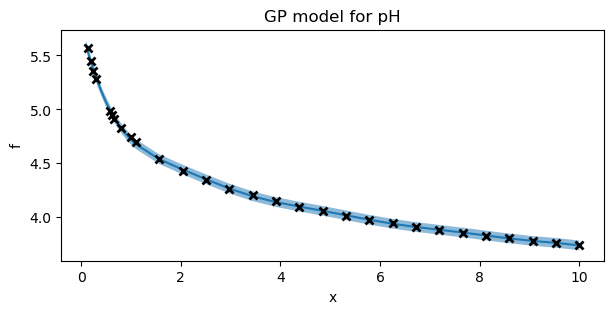

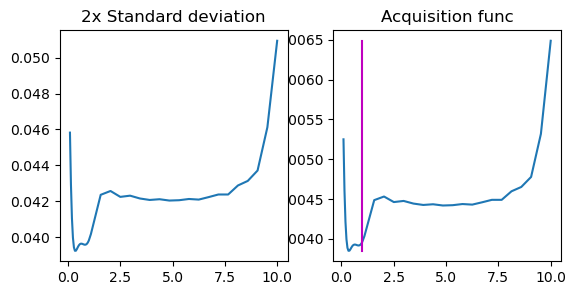

acid_vol 1.0
base_vol 1.0
pH (HH) [4.74]
counter value: 29
Acid/Base ratio measured: [1.]
pH Value: [4.74]
Optimization restart 1/5, f = -32.06124475830478
Optimization restart 2/5, f = -32.061244758116686
Optimization restart 3/5, f = -32.06124475795531
Optimization restart 4/5, f = -32.06124475827471
Optimization restart 5/5, f = -32.06124475310976
Variance is [[0.00049559]
 [0.00043314]
 [0.00039569]
 [0.00037513]
 [0.00036543]
 [0.0003622 ]
 [0.00036236]
 [0.00036386]
 [0.00036546]
 [0.00036649]
 [0.00036669]
 [0.00036609]
 [0.00036489]
 [0.00036337]
 [0.00036184]
 [0.00036062]
 [0.00035993]
 [0.00035998]
 [0.00036089]
 [0.0003627 ]
 [0.00036934]
 [0.00041681]
 [0.00042563]
 [0.00042066]
 [0.00042156]
 [0.0004184 ]
 [0.00041719]
 [0.00041791]
 [0.00041635]
 [0.00041677]
 [0.0004183 ]
 [0.00041753]
 [0.00042001]
 [0.00042347]
 [0.00042318]
 [0.0004329 ]
 [0.00043934]
 [0.00044941]
 [0.00050364]
 [0.0006099 ]]
The next ratio to investigate is [0.52631579]
Cdiag =  [0.00049559 0.00043

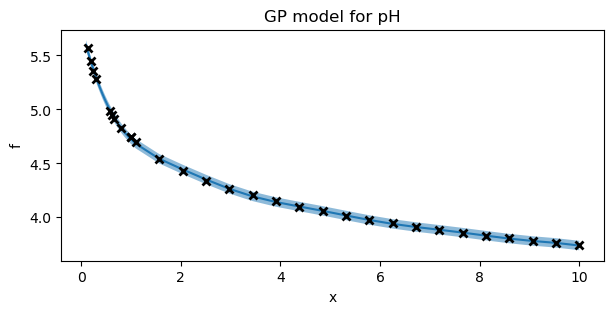

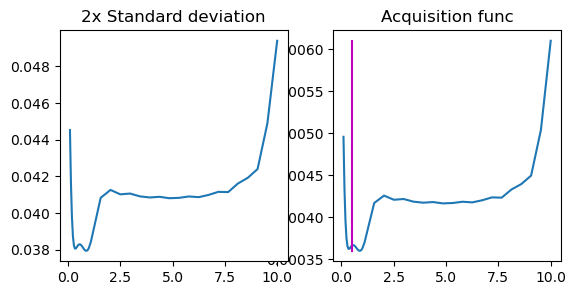

acid_vol 0.6896551724137931
base_vol 1.3103448275862069
pH (HH) [5.0187536]
counter value: 30
Acid/Base ratio measured: [0.52631579]
pH Value: [5.0187536]


In [121]:
Bayesian_optimization_pH()